In [5]:
#Here are the selected imports

import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from icrawler.builtin import GoogleImageCrawler
import matplotlib.image as mpimg
import os
from random import randrange
import cv2
import random
from PIL import Image
import json
from pathlib import Path
import torch
import matplotlib.pyplot as plt
plt.rcParams["savefig.bbox"] = 'tight'

from torchvision.transforms import v2
from torchvision.io import decode_image, read_file
from torchvision import tv_tensors
from matplotlib.patches import Rectangle
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

torch.manual_seed(1)



In [2]:
#Download Some Background image
directory = 'background'
if not os.path.exists(directory):
    os.makedirs(directory)

In [3]:

google_crawler = GoogleImageCrawler(
    parser_threads=2,
    downloader_threads=4,
    storage={'root_dir': 'background'}
)

for keyword in ['Las Vegas', 'Burj al arab', 'Seychelles', 'Azores', 'Canary islands', 'Budapest', 'Castle', 'Park', "Balaton", 'Porto']:
    google_crawler.crawl(
        keyword=keyword, max_num=20, file_idx_offset='auto')

2024-10-15 22:44:41,487 - INFO - icrawler.crawler - start crawling...
2024-10-15 22:44:41,488 - INFO - icrawler.crawler - starting 1 feeder threads...
2024-10-15 22:44:41,489 - INFO - feeder - thread feeder-001 exit
2024-10-15 22:44:41,490 - INFO - icrawler.crawler - starting 2 parser threads...
2024-10-15 22:44:41,492 - INFO - icrawler.crawler - starting 4 downloader threads...
2024-10-15 22:44:43,129 - INFO - parser - parsing result page https://www.google.com/search?q=Las+Vegas&ijn=0&start=0&tbs=&tbm=isch
2024-10-15 22:44:43,476 - ERROR - downloader - Response status code 404, file https://upload.wikimedia.org/wikipedia/commons/thumb/3/37/LV_Valley_montage.jpg
2024-10-15 22:44:43,503 - INFO - parser - no more page urls for thread parser-002 to parse
2024-10-15 22:44:43,504 - INFO - parser - thread parser-002 exit
2024-10-15 22:44:43,570 - INFO - downloader - image #1	https://media.cnn.com/api/v1/images/stellar/prod/180313182911-01-las-vegas-travel-strip.jpg
2024-10-15 22:44:43,915 -

['000001.jpg', '000002.jpg', '000003.jpg', '000004.jpg', '000005.jpg', '000006.jpg', '000007.jpg', '000008.jpg', '000009.jpg', '000010.jpg', '000011.jpg', '000012.jpg', '000013.jpg', '000014.jpg', '000015.jpg', '000016.jpg', '000017.jpg', '000018.jpg', '000019.jpg', '000020.jpg', '000021.jpg', '000022.jpg', '000023.jpg', '000024.jpg', '000025.jpg', '000026.jpg', '000027.jpg', '000028.jpg', '000029.jpg', '000030.jpg', '000031.jpg', '000032.jpg', '000033.jpg', '000034.jpg', '000035.jpg', '000036.jpg', '000037.jpg', '000038.jpg', '000039.jpg', '000040.jpg', '000041.jpg', '000042.jpg', '000043.jpg', '000044.jpg', '000045.jpg', '000046.png', '000047.jpg', '000048.jpg', '000049.jpg', '000050.jpg', '000051.jpg', '000052.jpg', '000053.jpg', '000054.jpg', '000055.jpg', '000056.jpg', '000057.jpg', '000058.jpg', '000059.jpg', '000060.jpg', '000061.jpg', '000062.jpg', '000063.jpg', '000064.jpg', '000065.jpg', '000066.jpg', '000067.png', '000068.jpg', '000069.jpg', '000070.jpg', '000071.jpg', '0000

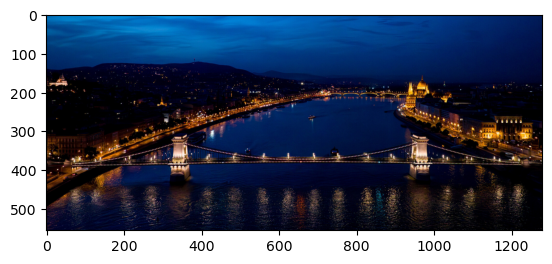

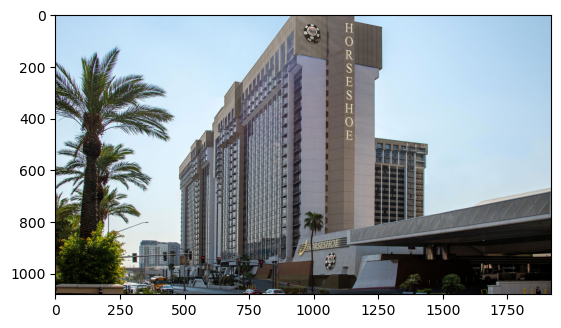

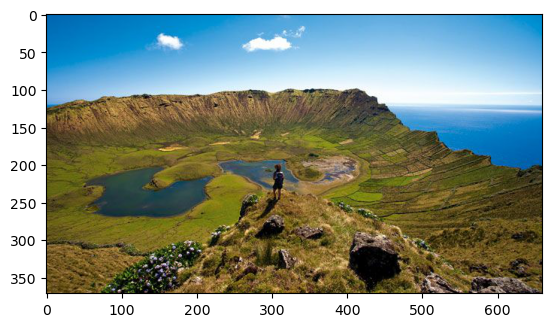

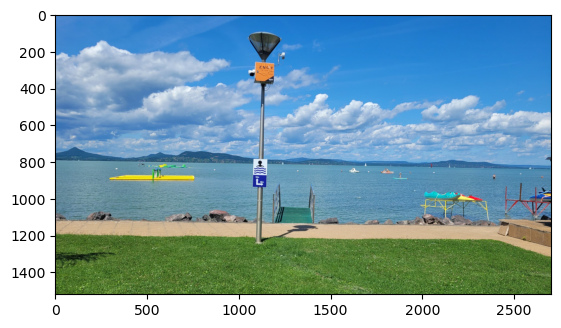

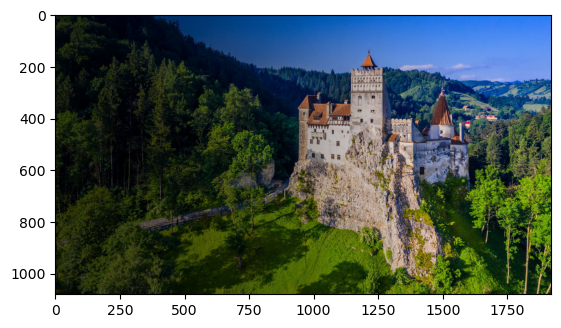

In [3]:

ImageNames = os.listdir(directory)


def display_sample_images(directory: str, ImageName: str) -> None:
    image = mpimg.imread(f"{directory}\\{ImageName}")
    plt.figure()
    plt.imshow(image)

#This is going to show 5 random pictures
for i in range(5):
    randomNumber = randrange(len(ImageNames))
    display_sample_images(directory, ImageNames[randomNumber])

In [5]:

def GenerateIamgesandBoundingBoxes(ImageNames: list):
    #We create a folder for the New Images
    ObjBGPath = "OBJBG"
    if not os.path.exists(ObjBGPath):
        os.makedirs(ObjBGPath)
    OBJBGPic = "Images"
    if not os.path.exists(f"{ObjBGPath}\\{OBJBGPic}"):
        os.makedirs(f"{ObjBGPath}\\{OBJBGPic}")
    OBJBGBounding = "BoundingBox"
    if not os.path.exists(f"{ObjBGPath}\\{OBJBGBounding}"):
        os.makedirs(f"{ObjBGPath}\\{OBJBGBounding}")


    ObjectDirectory = 'Object'
    #Gather all the names of the objects
    ObjectNames = os.listdir(ObjectDirectory)

    #We suffle the list of background 
    random.shuffle(ImageNames)

    ObjectID = {
        ObjectNames[0] : 0,
        ObjectNames[1] : 1,
        ObjectNames[2] : 2
    }


    for i in ImageNames:
        #Open the images
        BackgroundImage = Image.open(f"{directory}\\{i}")
        
        #We choose a random Statue
        randomStatue = randrange(len(ObjectNames))
        StatueImage = Image.open(f"{ObjectDirectory}\\{ObjectNames[randomStatue]}")

        #We get the Image Size and scale them down randomly
        w, h = StatueImage.size
        bgw, bgh = BackgroundImage.size
        randomScaleNumber = round(random.uniform(0.1, 0.4), 2)
        StatueImage.thumbnail((w*randomScaleNumber, h*randomScaleNumber))

        #We resize the Image to be smaller and for every image to be the same size
        BackgroundImage = BackgroundImage.resize((320, 320))

        #We get the now Modified Statue and BG size
        bgw, bgh = BackgroundImage.size
        w, h = StatueImage.size

        #We define some random start points in the BG where we will insert the files
        randomPlaceonBGWidth = random.randint(0, bgw-w)
        randomPlaceonBGHeight = random.randint(0, bgh-h)


        #We Paste the images to the BG
        BackgroundImage.paste(StatueImage, (randomPlaceonBGWidth,randomPlaceonBGHeight), StatueImage.convert('RGBA'))
        class_id = ObjectID[ObjectNames[randomStatue]]
        #Create the Bounding box text
        # class_id = ObjectID[ObjectNames[randomStatue]]
        # x_center = (randomPlaceonBGWidth + w / 2) / bgw
        # y_center = (randomPlaceonBGHeight + h / 2) / bgh
        # width = w / bgw
        # height = h / bgh
        # BoundingBox = {
        #     "class_id": class_id,
        #     "x_center": x_center,
        #     "y_center": y_center,
        #     "width": width,
        #     "height": height
        # }

        #This is for Pytorch tv_tensors._bounding_boxis 'CXCYWH' format
        x_center = int(randomPlaceonBGWidth + (w / 2))
        y_center = int(randomPlaceonBGHeight + (h / 2))
        width = w
        height = h
        BoundingBox = {
            "class_id": class_id,
            "x_center": x_center,
            "y_center": y_center,
            "width": width,
            "height": height
        }

        

        open_cv_image = np.array(BackgroundImage)
        #To convert RGB to BGR
        try:
            open_cv_image = open_cv_image[:, :, ::-1].copy()

            with open(f"{ObjBGPath}\\{OBJBGBounding}\\{i[:-4]}.json", "w") as output:
                json.dump(BoundingBox, output, indent=4)
            cv2.imwrite(f"{ObjBGPath}\\{OBJBGPic}\\{i[:-4]}.jpg", open_cv_image)
        except:
            print(f"This picture is png: {i}")





In [6]:
GenerateIamgesandBoundingBoxes(ImageNames)

This picture is png: 000098.png
This picture is png: 000257.png
This picture is png: 000317.png
This picture is png: 000510.png
This picture is png: 000046.png
This picture is png: 000110.png
This picture is png: 000500.png
This picture is png: 000312.png


In [41]:
import sys
def GenerateTrainValTest(TypeData: str, numImages: int, PathofImages: list, PathofBB = list) -> None:


    PATHPic= 'OBJBG//Images'
    PATHBoundingBox = 'OBJBG//BoundingBox'

    #Where to output the images
    BasePath = "root//dataset//"
    if not os.path.exists(BasePath):
        os.makedirs(BasePath)
    

    
    OutPathIm = os.path.join(BasePath,"all_image//images")
    OutPathBB = os.path.join(BasePath,"all_image//labels")
    OutPathBBYolo = os.path.join(BasePath, "all_image//YoloLabels")
    if not os.path.exists(OutPathIm):
                os.makedirs(OutPathIm)
    if not os.path.exists(OutPathBB):
                os.makedirs(OutPathBB)
    if not os.path.exists(OutPathBBYolo):
                os.makedirs(OutPathBBYolo)
    filename = "all_images"
        

    
    numberofimages = len(PathofImages)
    NumberAugIm = int(numImages/numberofimages)
    #We need a for loop to go through every image, and create copies of it with augmentation and save them
    ProcessImageNumber = 0
    for i in range(numberofimages):

        # Read the image file into a tensor of bytes
        useImage = os.path.join(PATHPic, PathofImages[i])
        useBB = os.path.join(PATHBoundingBox, PathofBB[i])

        #Load the given image
        img_path = Path(useImage)
        #Load the given bb
        with open(useBB, 'r') as file:
            BoundingBox = json.load(file)


        # Use read_file to load the image content
        img = decode_image(read_file(img_path))

        boxes = tv_tensors.BoundingBoxes(
            [[BoundingBox['x_center'], BoundingBox['y_center'], BoundingBox['width'], BoundingBox['height']]],  # Format: [center_x, center_y, width, height]
            format='CXCYWH', 
            canvas_size=(img.shape[1], img.shape[2])  # Canvas size is (height, width)
        )
        for j in range(NumberAugIm):
            transforms = v2.Compose([
                v2.ToDtype(torch.float32, scale=True),
                v2.RandomHorizontalFlip(p=0.5),
                v2.RandomAffine(random.randint(0, 360)),
                v2.RandomVerticalFlip(p=0.5),
                v2.GaussianBlur(random.randrange(1, 4, 2))
            ])

            out_img, out_boxes = transforms(img, boxes)
            # Convert out_img to a NumPy array

            # Manually convert boxes from CXCYWH to XYXY
            # out_boxes is still in CXCYWH format
            #boxes_tensor = out_boxes.tensor.numpy()  # Convert to numpy array for processing
            # out_boxes_xyxy = []

            for box in out_boxes:
                x_center, y_center, width, height = box
                

            xYolo = x_center/img.shape[2]
            yYolo = y_center/img.shape[1]
            widthYolo = width/img.shape[2]
            heightYolo = height/img.shape[1]



            ModifiedBoundingBox = {
                "class_id": BoundingBox["class_id"],
                "x_center":x_center.item(),
                "y_center": y_center.item(),
                "width": width.item(),
                "height": height.item()
            }

            
            YoloString = f"{BoundingBox['class_id']} {xYolo.item():.6f} {yYolo.item():.6f} {widthYolo.item():.6f} {heightYolo.item():.6f}"



            out_img_np = out_img.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)

            with open(f"{OutPathBB}\\{filename}{ProcessImageNumber:05d}.json", "w") as output:
                out_img_np = (out_img_np * 255).astype(np.uint8)
                out_img_np = cv2.cvtColor(out_img_np, cv2.COLOR_RGB2BGR)
                json.dump(ModifiedBoundingBox, output, indent=4)
            with open(f"{OutPathBBYolo}\\{filename}{ProcessImageNumber:05d}.txt", "w") as outputYOLO:
                  outputYOLO.write(YoloString)
            cv2.imwrite(f"{OutPathIm}\\{filename}{ProcessImageNumber:05d}.jpg", out_img_np)
            
            ProcessImageNumber += 1





Hogyan tovább:


Vasárnap:
Megcsináljuk a train, valid, test képeket és könyvtárformát, úgy ahogy a példában van mert az a legegyszerűbb. Elek

In [42]:
import shutil
def SortingImages(TypeData, imagelist, jsonlist, yololist):
    #Where to output the images
    BasePath = "root\\dataset\\"
    if not os.path.exists(BasePath):
        os.makedirs(BasePath)
    match TypeData:
        case "train":
            OutPathIm = os.path.join(BasePath,"train\\images")
            OutPathBB = os.path.join(BasePath,"train\\labels")
            OutPathBBYOLO = os.path.join(BasePath,"train\\YOLOlabels")
            if not os.path.exists(OutPathIm):
                os.makedirs(OutPathIm)
            if not os.path.exists(OutPathBB):
                os.makedirs(OutPathBB)
            if not os.path.exists(OutPathBBYOLO):
                os.makedirs(OutPathBBYOLO)
            filename = "train"
        case "val":
            OutPathIm = os.path.join(BasePath,"val\\images")
            OutPathBB = os.path.join(BasePath,"val\\labels")
            OutPathBBYOLO = os.path.join(BasePath,"val\\YOLOlabels")
            if not os.path.exists(OutPathIm):
                os.makedirs(OutPathIm)
            if not os.path.exists(OutPathBB):
                os.makedirs(OutPathBB)
            if not os.path.exists(OutPathBBYOLO):
                os.makedirs(OutPathBBYOLO)
            filename = "val"
        case "test":
            OutPathIm = os.path.join(BasePath,"test\\images")
            OutPathBB = os.path.join(BasePath,"test\\labels")
            OutPathBBYOLO = os.path.join(BasePath,"test\\YOLOlabels")
            if not os.path.exists(OutPathIm):
                os.makedirs(OutPathIm)
            if not os.path.exists(OutPathBB):
                os.makedirs(OutPathBB)
            if not os.path.exists(OutPathBBYOLO):
                os.makedirs(OutPathBBYOLO)
            filename = "test"
    for i in imagelist:
        imorig = cv2.imread(f"{BasePath}\\all_image\\images\\{i}")
        cv2.imwrite(f"{OutPathIm}\\{i}", imorig)

    for j in jsonlist:
        shutil.copyfile(f"{BasePath}\\all_image\\labels\\{j}", f"{OutPathBB}\\{j}")
    
    for h in yololist:
        shutil.copyfile(f"{BasePath}\\all_image\\YOLOlabels\\{h}", f"{OutPathBBYOLO}\\{h}")
    

In [43]:
#Generate the Test, Train, Val datasets, with x, y, z images in each
GenImPath = "OBJBG\Images"
GenBBPath = "OBJBG\BoundingBox"



GeneratedImages = os.listdir(GenImPath)
GeneratedBB = os.listdir(GenBBPath)

GenerateTrainValTest(TypeData="all_image",numImages=3000, PathofImages=GeneratedImages, PathofBB=GeneratedBB)

AllImagePath = "root\\dataset\\all_image\\images"
AllImageBB = "root\\dataset\\all_image\\labels"
AllImageYoloBB = "root\\dataset\\all_image\\YoloLabels"


AllImages = os.listdir(AllImagePath)
AllBB = os.listdir(AllImageBB)
AllYOLOBB = os.listdir(AllImageYoloBB)
zipped = list(zip(AllImages, AllBB, AllYOLOBB))
random.shuffle(zipped)
AllImages, AllBB, AllYOLOBB = zip(*zipped)

TrainIm = AllImages[:int(len(AllImages)*0.7)]
TrainBB = AllBB[:int(len(AllBB)*0.7)]
TrainYOLO = AllYOLOBB[:int(len(AllYOLOBB)*0.7)]

ValIm = AllImages[int(len(AllImages)*0.7):int(len(AllImages)*0.9)]
ValBB = AllBB[int(len(AllBB)*0.7):int(len(AllBB)*0.9)]
ValYOLO = AllYOLOBB[int(len(AllYOLOBB)*0.7):int(len(AllYOLOBB)*0.9)]

TestIm = AllImages[int(len(AllImages)*0.9):]
TestBB = AllBB[int(len(AllBB)*0.9):]
TestYOLO = AllYOLOBB[int(len(AllYOLOBB)*0.9):]




SortingImages("train", TrainIm, TrainBB, TrainYOLO)
SortingImages("val", ValIm, ValBB, ValYOLO)
SortingImages("test", TestIm, TestBB, TestYOLO)



In [44]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, 'images')
        self.label_dir = os.path.join(root_dir, 'YOLOlabels')
        self.image_filenames = os.listdir(self.image_dir)
        self.transform = transform  # Default to ToTensor if no transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.image_dir, img_name)
        
        # Load the image safely using PIL and convert to RGB
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return None

        # Load the corresponding label (json file)
        #This is for cxcywh
        #label_name = img_name.replace('.jpg', '.json')  # Ensure this matches your label format

        #This is for Yolo
        label_name = img_name.replace('.jpg', '.txt')

        label_path = os.path.join(self.label_dir, label_name)
        
       #This is for cxcywh 
        # try:
        #     with open(label_path, 'r') as f:
        #         label_data = json.load(f)
        # except Exception as e:
        #     print(f"Error loading label {label_path}: {e}")
        #     return None

        # # Extract the bounding box information from the label
        # try:
        #     class_id = label_data['class_id']
        #     x_center = label_data['x_center']
        #     y_center = label_data['y_center']
        #     width = label_data['width']
        #     height = label_data['height']

        #     # Convert bounding box from (x_center, y_center, width, height) to (x_min, y_min, x_max, y_max)
        #     # bbox = [
        #     #     x_center - width / 2,  # x_min
        #     #     y_center - height / 2,  # y_min
        #     #     x_center + width / 2,  # x_max
        #     #     y_center + height / 2  # y_max
        #     # ]


        # except KeyError as e:
        #     print(f"Missing key in label {label_path}: {e}")
        #     return None

        #This isfor YOLO
        with open(label_path, 'r') as YoloData:
            line = YoloData.readline().strip()
            values = line.split()
            class_id = int(values[0])
            x_center = float(values[1])
            y_center = float(values[2])
            width = float(values[3])
            height = float(values[4])

        bbox = [
                x_center,
                y_center,
                width,
                height
            ]
        # Apply any transformations on the image (if specified)
        if self.transform:
            image = self.transform(image)

        # Return image and label as a dictionary
        return {
            'image': image,
            'label': torch.tensor(class_id, dtype=torch.long),
            'bbox': torch.tensor(bbox, dtype=torch.float32)  # normalized bbox
        }
  



In [45]:
def visualize_dataset(dataset, numberofimages):
    ObjectDirectory = 'Object'  
    #Gather all the names of the objects
    ObjectNames = os.listdir(ObjectDirectory)

    #We suffle the list of background 
    random.shuffle(ImageNames)

    ObjectID = {
        0: ObjectNames[0][:-4],
        1: ObjectNames[1][:-4],
        2: ObjectNames[2][:-4]
    }

    

    for i in range(numberofimages):
        imagenumber = random.randint(0, len(dataset)-1)
        sample = dataset[imagenumber]
        image = sample['image']
        classid = sample['label'].item()
        classname = ObjectID[classid]

        image = image.permute(1, 2, 0).numpy()
        x_min, y_min, x_max, y_max = sample['bbox']
        bbox_width = x_max - x_min
        bbox_height = y_max - y_min

        fig, ax = plt.subplots(1)
        ax.imshow(image)
        rect = Rectangle((x_min, y_min), bbox_width, bbox_height, linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
        ax.add_patch(rect)
        plt.title(f"Sample: {imagenumber}, Class: {classname}")
        plt.show()


In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [47]:
import torch
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

class CustomObjectDetectionModel(nn.Module):
    def __init__(self, num_classes):
        super(CustomObjectDetectionModel, self).__init__()
        # Define layers (same as before)
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
        self.bbox_regressor = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 4)  # Output: (x_center, y_center, width, height)
        )
        self.transform = transforms.Compose([
            transforms.Resize((320, 320)),
            transforms.ToTensor(),  # Convert image to tensor
        ])

    def forward(self, x):
        features = self.features(x)
        class_logits = self.classifier(features)
        bbox_regression = self.bbox_regressor(features)
        return class_logits, bbox_regression

    def predict(self, image_path, device='cpu', class_labels=None):
        # Load and preprocess the image
        image = Image.open(image_path).convert('RGB')
        original_image = image.copy()  # Save the original image for drawing
        image = self.transform(image).unsqueeze(0).to(device)
        
        # Set the model to evaluation mode
        self.eval()
        
        with torch.no_grad():
            # Forward pass
            class_logits, bbox_regression = self.forward(image)
        
        # Get predicted class and bounding box
        class_probs = torch.softmax(class_logits, dim=1)
        predicted_class = torch.argmax(class_probs, dim=1).item()
        predicted_class_prob = class_probs[0, predicted_class].item()
        predicted_bbox = bbox_regression[0].cpu().numpy()  # (x_center, y_center, width, height)

        # Convert bbox from (x_center, y_center, width, height) to (x_min, y_min, x_max, y_max)
        # x_center, y_center, width, height = predicted_bbox
        # x_min = (x_center - width) / 2
        # y_min = (y_center - height) / 2
        # x_max = (x_center + width) / 2
        # y_max = (y_center + height) / 2

        x_min, y_min, x_max, y_max = predicted_bbox
        # x_min = x_center - (width/2)
        # y_min = y_center - (height/ 2)
        # x_max = x_center + (width / 2)
        # y_max = y_center + (height / 2)

        # Draw the bounding box and the class label on the image
        # draw = ImageDraw.Draw(original_image)
        # draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=3)

        # Draw the class label
        # if class_labels:  # If a list of class labels is provided
        #     label = f"{class_labels[predicted_class]}: {predicted_class_prob:.2f}"
        # else:
        #     label = f"Class {predicted_class}: {predicted_class_prob:.2f}"
        
        # Optional: Draw the label text above the bounding box
        # font = ImageFont.load_default()
        # draw.text((x_min, y_min - 10), label, fill="red", font=font)
        
        # Display the image with the bounding box
        # plt.imshow(original_image)
        # plt.axis('off')
        # plt.show()

        return {
            'class_id': predicted_class,
            'class_prob': predicted_class_prob,
            'bbox': [x_min, y_min, x_max, y_max]
        }


In [48]:
import torch
import torch.optim as optim
from tqdm import tqdm

# Function to calculate accuracy
def calculate_accuracy(logits, labels):
    _, predicted_classes = torch.max(logits, 1)
    correct = (predicted_classes == labels).sum().item()
    accuracy = correct / labels.size(0)  # Correct predictions divided by the total number of labels
    return accuracy

# Define training function
def train_model(model, train_loader, val_loader, num_epochs=10, lr=0.001, device='cuda'):
    # Move the model to the correct device (GPU/CPU)
    model = model.to(device)
    
    # Define optimizer and loss functions
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    classification_loss_fn = nn.CrossEntropyLoss()
    bbox_loss_fn = nn.SmoothL1Loss()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        total_accuracy = 0.0
        train_regression_losses = []

        # Iterate over the training data
        for batch in tqdm(train_loader):
            images = batch['image'].to(device)
            labels = batch['label'].to(device)
            bboxes = batch['bbox'].to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            class_logits, bbox_regression = model(images)

            # Remove extra dimension from bbox_list if present
            bboxes = torch.squeeze(bboxes, dim=1)

            # Calculate losses
            classification_loss = classification_loss_fn(class_logits, labels)
            bbox_loss = bbox_loss_fn(bbox_regression, bboxes)

            # Total loss is a weighted sum of classification and bbox regression loss
            loss = classification_loss + bbox_loss

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate accuracy
            batch_accuracy = calculate_accuracy(class_logits, labels)
            total_accuracy += batch_accuracy

        avg_loss = running_loss / len(train_loader)
        avg_accuracy = total_accuracy / len(train_loader)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy*100:.2f}%")

        # Optionally, validate the model after each epoch
        validate_model(model, val_loader, device)

# Validation function (with accuracy)
def validate_model(model, val_loader, device):
    model.eval()
    total_loss = 0.0
    total_accuracy = 0.0
    with torch.no_grad():
        for batch in val_loader:
            images = batch['image'].to(device)
            labels = batch['label'].to(device)
            bboxes = batch['bbox'].to(device)

            # Forward pass
            class_logits, bbox_regression = model(images)

            # Calculate validation losses
            classification_loss = nn.CrossEntropyLoss()(class_logits, labels)
            bbox_loss = nn.SmoothL1Loss()(bbox_regression, bboxes)

            loss = classification_loss + bbox_loss
            total_loss += loss.item()

            # Calculate accuracy
            batch_accuracy = calculate_accuracy(class_logits, labels)
            total_accuracy += batch_accuracy

    avg_loss = total_loss / len(val_loader)
    avg_accuracy = total_accuracy / len(val_loader)
    print(f"Validation Loss: {avg_loss:.4f}, Validation Accuracy: {avg_accuracy*100:.2f}%")



In [49]:
# Assuming you've already defined your DataLoader
transform = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.ToTensor(),  # Convert image to tensor
])

train_dataset = ImageDataset(root_dir='root\\dataset\\train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, pin_memory=False)

val_dataset = ImageDataset(root_dir='root\\dataset\\val', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, pin_memory=False)

# Instantiate the model
num_classes = 3  # Update based on your number of classes
model = CustomObjectDetectionModel(num_classes)
#visualize_dataset(train_dataset, 5)


train_model(model, train_loader, val_loader, num_epochs=70, lr=0.001, device=device)
torch.save(model.state_dict(), 'model_weights_new_coordinate.pth')

100%|██████████| 130/130 [00:40<00:00,  3.18it/s]


Epoch [1/70], Loss: 1.1127, Accuracy: 37.36%
Validation Loss: 1.1057, Validation Accuracy: 38.01%


100%|██████████| 130/130 [00:15<00:00,  8.61it/s]


Epoch [2/70], Loss: 1.0926, Accuracy: 43.17%
Validation Loss: 1.0679, Validation Accuracy: 44.09%


100%|██████████| 130/130 [00:15<00:00,  8.63it/s]


Epoch [3/70], Loss: 1.0769, Accuracy: 42.93%
Validation Loss: 1.0608, Validation Accuracy: 46.45%


100%|██████████| 130/130 [00:14<00:00,  8.70it/s]


Epoch [4/70], Loss: 1.0692, Accuracy: 45.19%
Validation Loss: 1.0482, Validation Accuracy: 48.31%


100%|██████████| 130/130 [00:14<00:00,  8.72it/s]


Epoch [5/70], Loss: 1.0441, Accuracy: 46.59%
Validation Loss: 1.0398, Validation Accuracy: 46.45%


100%|██████████| 130/130 [00:14<00:00,  8.67it/s]


Epoch [6/70], Loss: 1.0286, Accuracy: 49.18%
Validation Loss: 1.0293, Validation Accuracy: 50.51%


100%|██████████| 130/130 [00:15<00:00,  8.35it/s]


Epoch [7/70], Loss: 1.0177, Accuracy: 48.56%
Validation Loss: 1.0695, Validation Accuracy: 47.13%


100%|██████████| 130/130 [00:14<00:00,  8.81it/s]


Epoch [8/70], Loss: 1.0078, Accuracy: 49.76%
Validation Loss: 1.0490, Validation Accuracy: 48.82%


100%|██████████| 130/130 [00:14<00:00,  8.72it/s]


Epoch [9/70], Loss: 0.9895, Accuracy: 51.06%
Validation Loss: 1.0119, Validation Accuracy: 52.36%


100%|██████████| 130/130 [00:14<00:00,  8.68it/s]


Epoch [10/70], Loss: 0.9678, Accuracy: 52.84%
Validation Loss: 0.9981, Validation Accuracy: 51.52%


100%|██████████| 130/130 [00:15<00:00,  8.67it/s]


Epoch [11/70], Loss: 0.9713, Accuracy: 52.84%
Validation Loss: 0.9574, Validation Accuracy: 53.55%


100%|██████████| 130/130 [00:14<00:00,  8.71it/s]


Epoch [12/70], Loss: 0.9439, Accuracy: 55.05%
Validation Loss: 0.9643, Validation Accuracy: 53.21%


100%|██████████| 130/130 [00:15<00:00,  8.62it/s]


Epoch [13/70], Loss: 0.9357, Accuracy: 56.49%
Validation Loss: 0.9368, Validation Accuracy: 53.72%


100%|██████████| 130/130 [00:14<00:00,  8.72it/s]


Epoch [14/70], Loss: 0.9153, Accuracy: 57.26%
Validation Loss: 0.9509, Validation Accuracy: 55.24%


100%|██████████| 130/130 [00:15<00:00,  8.67it/s]


Epoch [15/70], Loss: 0.8919, Accuracy: 57.93%
Validation Loss: 0.9933, Validation Accuracy: 52.20%


100%|██████████| 130/130 [00:15<00:00,  8.63it/s]


Epoch [16/70], Loss: 0.9024, Accuracy: 56.78%
Validation Loss: 0.9100, Validation Accuracy: 56.42%


100%|██████████| 130/130 [00:15<00:00,  8.59it/s]


Epoch [17/70], Loss: 0.8748, Accuracy: 58.80%
Validation Loss: 1.0083, Validation Accuracy: 50.68%


100%|██████████| 130/130 [00:15<00:00,  8.63it/s]


Epoch [18/70], Loss: 0.8714, Accuracy: 60.38%
Validation Loss: 0.8900, Validation Accuracy: 57.60%


100%|██████████| 130/130 [00:15<00:00,  8.64it/s]


Epoch [19/70], Loss: 0.8506, Accuracy: 59.66%
Validation Loss: 0.8933, Validation Accuracy: 56.93%


100%|██████████| 130/130 [00:15<00:00,  8.65it/s]


Epoch [20/70], Loss: 0.8427, Accuracy: 60.87%
Validation Loss: 0.8363, Validation Accuracy: 62.33%


100%|██████████| 130/130 [00:14<00:00,  8.74it/s]


Epoch [21/70], Loss: 0.8388, Accuracy: 60.91%
Validation Loss: 0.8757, Validation Accuracy: 59.12%


100%|██████████| 130/130 [00:14<00:00,  8.68it/s]


Epoch [22/70], Loss: 0.8297, Accuracy: 62.55%
Validation Loss: 0.8396, Validation Accuracy: 59.46%


100%|██████████| 130/130 [00:14<00:00,  8.78it/s]


Epoch [23/70], Loss: 0.8087, Accuracy: 63.32%
Validation Loss: 0.8462, Validation Accuracy: 60.81%


100%|██████████| 130/130 [00:14<00:00,  8.77it/s]


Epoch [24/70], Loss: 0.7968, Accuracy: 64.28%
Validation Loss: 0.7832, Validation Accuracy: 64.70%


100%|██████████| 130/130 [00:15<00:00,  8.66it/s]


Epoch [25/70], Loss: 0.7795, Accuracy: 64.52%
Validation Loss: 0.9363, Validation Accuracy: 55.41%


100%|██████████| 130/130 [00:14<00:00,  8.75it/s]


Epoch [26/70], Loss: 0.7617, Accuracy: 65.67%
Validation Loss: 0.7962, Validation Accuracy: 62.33%


100%|██████████| 130/130 [00:14<00:00,  8.67it/s]


Epoch [27/70], Loss: 0.7630, Accuracy: 65.87%
Validation Loss: 0.8134, Validation Accuracy: 60.47%


100%|██████████| 130/130 [00:14<00:00,  8.71it/s]


Epoch [28/70], Loss: 0.7505, Accuracy: 66.11%
Validation Loss: 0.8461, Validation Accuracy: 64.53%


100%|██████████| 130/130 [00:15<00:00,  8.63it/s]


Epoch [29/70], Loss: 0.7429, Accuracy: 68.08%
Validation Loss: 0.8090, Validation Accuracy: 60.98%


100%|██████████| 130/130 [00:15<00:00,  8.65it/s]


Epoch [30/70], Loss: 0.7131, Accuracy: 68.51%
Validation Loss: 1.1917, Validation Accuracy: 45.61%


100%|██████████| 130/130 [00:14<00:00,  8.74it/s]


Epoch [31/70], Loss: 0.6972, Accuracy: 69.71%
Validation Loss: 0.6886, Validation Accuracy: 69.43%


100%|██████████| 130/130 [00:14<00:00,  8.67it/s]


Epoch [32/70], Loss: 0.6824, Accuracy: 70.91%
Validation Loss: 0.6927, Validation Accuracy: 72.13%


100%|██████████| 130/130 [00:14<00:00,  8.68it/s]


Epoch [33/70], Loss: 0.6819, Accuracy: 70.87%
Validation Loss: 0.6554, Validation Accuracy: 72.13%


100%|██████████| 130/130 [00:14<00:00,  8.73it/s]


Epoch [34/70], Loss: 0.6712, Accuracy: 71.20%
Validation Loss: 0.7295, Validation Accuracy: 67.40%


100%|██████████| 130/130 [00:14<00:00,  8.69it/s]


Epoch [35/70], Loss: 0.6685, Accuracy: 71.39%
Validation Loss: 0.6325, Validation Accuracy: 73.31%


100%|██████████| 130/130 [00:14<00:00,  8.76it/s]


Epoch [36/70], Loss: 0.6436, Accuracy: 72.16%
Validation Loss: 0.7463, Validation Accuracy: 66.72%


100%|██████████| 130/130 [00:15<00:00,  8.63it/s]


Epoch [37/70], Loss: 0.6493, Accuracy: 72.12%
Validation Loss: 0.6442, Validation Accuracy: 73.14%


100%|██████████| 130/130 [00:14<00:00,  8.73it/s]


Epoch [38/70], Loss: 0.5965, Accuracy: 74.95%
Validation Loss: 0.6144, Validation Accuracy: 72.97%


100%|██████████| 130/130 [00:15<00:00,  8.66it/s]


Epoch [39/70], Loss: 0.6293, Accuracy: 72.12%
Validation Loss: 0.6370, Validation Accuracy: 72.13%


100%|██████████| 130/130 [00:14<00:00,  8.67it/s]


Epoch [40/70], Loss: 0.6282, Accuracy: 72.93%
Validation Loss: 0.6608, Validation Accuracy: 70.78%


100%|██████████| 130/130 [00:14<00:00,  8.76it/s]


Epoch [41/70], Loss: 0.5603, Accuracy: 76.92%
Validation Loss: 0.6577, Validation Accuracy: 68.41%


100%|██████████| 130/130 [00:14<00:00,  8.69it/s]


Epoch [42/70], Loss: 0.5536, Accuracy: 75.87%
Validation Loss: 0.5586, Validation Accuracy: 77.87%


100%|██████████| 130/130 [00:14<00:00,  8.73it/s]


Epoch [43/70], Loss: 0.5729, Accuracy: 77.21%
Validation Loss: 0.6120, Validation Accuracy: 76.52%


100%|██████████| 130/130 [00:14<00:00,  8.68it/s]


Epoch [44/70], Loss: 0.5708, Accuracy: 75.43%
Validation Loss: 0.5512, Validation Accuracy: 80.57%


100%|██████████| 130/130 [00:14<00:00,  8.78it/s]


Epoch [45/70], Loss: 0.5604, Accuracy: 77.84%
Validation Loss: 0.5822, Validation Accuracy: 74.32%


100%|██████████| 130/130 [00:15<00:00,  8.61it/s]


Epoch [46/70], Loss: 0.5314, Accuracy: 77.79%
Validation Loss: 0.5680, Validation Accuracy: 76.18%


100%|██████████| 130/130 [00:14<00:00,  8.67it/s]


Epoch [47/70], Loss: 0.5050, Accuracy: 78.75%
Validation Loss: 0.8709, Validation Accuracy: 62.16%


100%|██████████| 130/130 [00:14<00:00,  8.73it/s]


Epoch [48/70], Loss: 0.5402, Accuracy: 77.02%
Validation Loss: 0.5248, Validation Accuracy: 80.24%


100%|██████████| 130/130 [00:14<00:00,  8.68it/s]


Epoch [49/70], Loss: 0.4908, Accuracy: 80.38%
Validation Loss: 0.9430, Validation Accuracy: 60.47%


100%|██████████| 130/130 [00:14<00:00,  8.71it/s]


Epoch [50/70], Loss: 0.4868, Accuracy: 80.96%
Validation Loss: 0.4967, Validation Accuracy: 80.74%


100%|██████████| 130/130 [00:14<00:00,  8.69it/s]


Epoch [51/70], Loss: 0.4823, Accuracy: 80.14%
Validation Loss: 0.4965, Validation Accuracy: 80.91%


100%|██████████| 130/130 [00:14<00:00,  8.71it/s]


Epoch [52/70], Loss: 0.4797, Accuracy: 80.43%
Validation Loss: 0.5390, Validation Accuracy: 76.69%


100%|██████████| 130/130 [00:14<00:00,  8.69it/s]


Epoch [53/70], Loss: 0.4784, Accuracy: 80.77%
Validation Loss: 0.4300, Validation Accuracy: 83.61%


100%|██████████| 130/130 [00:14<00:00,  8.70it/s]


Epoch [54/70], Loss: 0.4554, Accuracy: 81.88%
Validation Loss: 0.4717, Validation Accuracy: 80.74%


100%|██████████| 130/130 [00:15<00:00,  8.63it/s]


Epoch [55/70], Loss: 0.4534, Accuracy: 81.25%
Validation Loss: 0.5049, Validation Accuracy: 79.56%


100%|██████████| 130/130 [00:15<00:00,  8.64it/s]


Epoch [56/70], Loss: 0.4555, Accuracy: 81.01%
Validation Loss: 0.4660, Validation Accuracy: 82.94%


100%|██████████| 130/130 [00:15<00:00,  8.58it/s]


Epoch [57/70], Loss: 0.4598, Accuracy: 80.82%
Validation Loss: 0.4546, Validation Accuracy: 82.77%


100%|██████████| 130/130 [00:15<00:00,  8.62it/s]


Epoch [58/70], Loss: 0.4241, Accuracy: 83.51%
Validation Loss: 0.4825, Validation Accuracy: 79.56%


100%|██████████| 130/130 [00:15<00:00,  8.62it/s]


Epoch [59/70], Loss: 0.4253, Accuracy: 83.17%
Validation Loss: 0.4115, Validation Accuracy: 84.46%


100%|██████████| 130/130 [00:14<00:00,  8.70it/s]


Epoch [60/70], Loss: 0.3923, Accuracy: 84.71%
Validation Loss: 0.3820, Validation Accuracy: 86.99%


100%|██████████| 130/130 [00:15<00:00,  8.66it/s]


Epoch [61/70], Loss: 0.4121, Accuracy: 83.03%
Validation Loss: 0.5392, Validation Accuracy: 77.03%


100%|██████████| 130/130 [00:15<00:00,  8.64it/s]


Epoch [62/70], Loss: 0.4046, Accuracy: 83.94%
Validation Loss: 0.4331, Validation Accuracy: 83.28%


100%|██████████| 130/130 [00:15<00:00,  8.63it/s]


Epoch [63/70], Loss: 0.4254, Accuracy: 83.12%
Validation Loss: 0.8774, Validation Accuracy: 64.19%


100%|██████████| 130/130 [00:15<00:00,  8.66it/s]


Epoch [64/70], Loss: 0.3928, Accuracy: 84.71%
Validation Loss: 0.3698, Validation Accuracy: 85.47%


100%|██████████| 130/130 [00:14<00:00,  8.79it/s]


Epoch [65/70], Loss: 0.3722, Accuracy: 85.34%
Validation Loss: 0.5193, Validation Accuracy: 78.72%


100%|██████████| 130/130 [00:14<00:00,  8.77it/s]


Epoch [66/70], Loss: 0.3552, Accuracy: 85.58%
Validation Loss: 0.3702, Validation Accuracy: 86.99%


100%|██████████| 130/130 [00:14<00:00,  8.80it/s]


Epoch [67/70], Loss: 0.3535, Accuracy: 86.54%
Validation Loss: 0.3296, Validation Accuracy: 89.53%


100%|██████████| 130/130 [00:14<00:00,  8.78it/s]


Epoch [68/70], Loss: 0.3602, Accuracy: 85.24%
Validation Loss: 0.3546, Validation Accuracy: 86.82%


100%|██████████| 130/130 [00:14<00:00,  8.75it/s]


Epoch [69/70], Loss: 0.3336, Accuracy: 86.54%
Validation Loss: 0.4070, Validation Accuracy: 83.61%


100%|██████████| 130/130 [00:15<00:00,  8.66it/s]


Epoch [70/70], Loss: 0.3364, Accuracy: 86.44%
Validation Loss: 0.3212, Validation Accuracy: 89.02%


C:\Users\msi\AppData\Local\Temp\ipykernel_19128\196796894.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_weights_new_coordinate.

Accuracy on test set: 0.86 
Precision: 0.8738, Recall: 0.8652, mAP: 0.8982


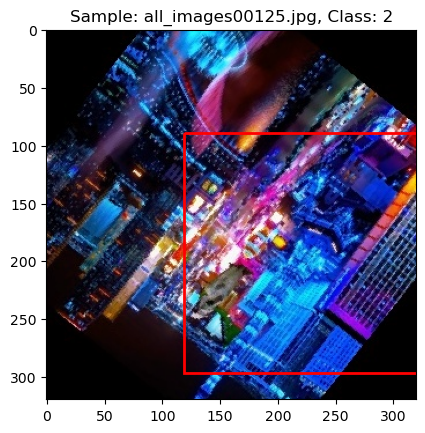

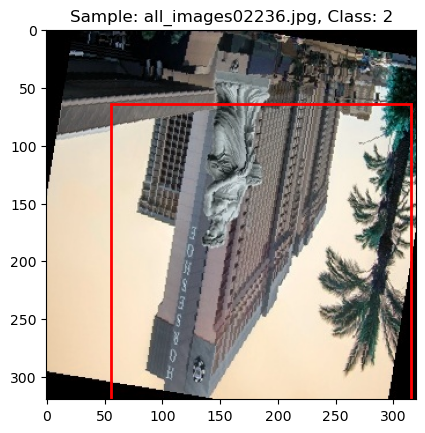

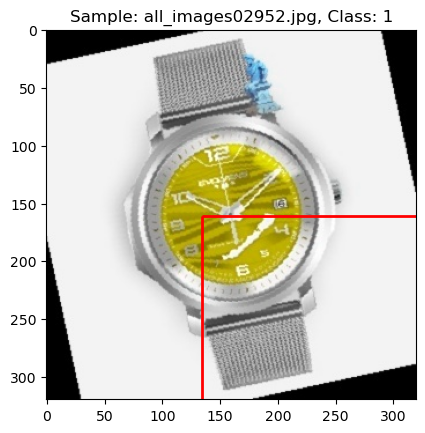

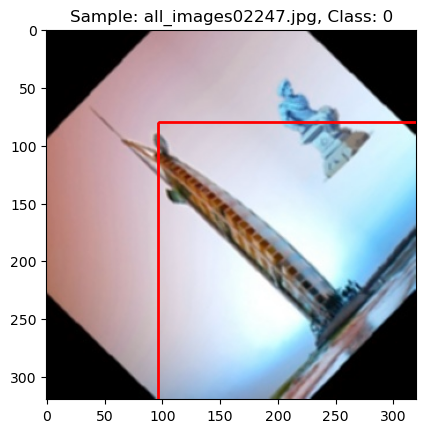

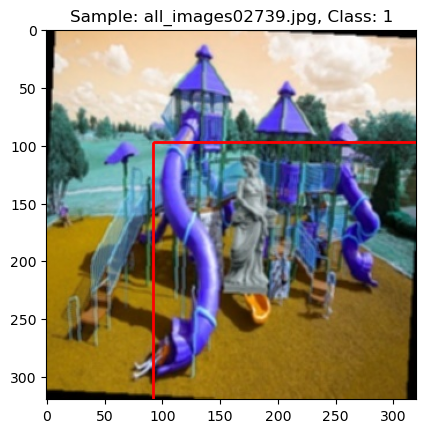

In [60]:
#Test accuracy
model = CustomObjectDetectionModel(3)
model.load_state_dict(torch.load('model_weights_new_coordinate.pth'))

TestPath = "root\\dataset\\test\\images"
TestPathBB = "root\\dataset\\test\\YOLOlabels"

TestImages = os.listdir(TestPath)
TestBB = os.listdir(TestPathBB)
# Move model to appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Set the model to evaluation mode
model.eval()


correctimages = 0

all_targets = []
all_predictions = []
# Predict on a new image
for i in range(len(TestImages)):
    image_path = f'root/dataset/test/images/{TestImages[i]}'


    #This is CXCYWH
    # with open(f'root/dataset/test/labels/{TestBB[i]}', 'r') as file:
    #     data = json.load(file)
    # realclass = data["class_id"]

    #This is YOLO format
    with open(f'root/dataset/test/YOLOlabels/{TestBB[i]}', 'r') as YoloData:
            line = YoloData.readline().strip()
            values = line.split()
            realclass = int(values[0])
    

    prediction = model.predict(image_path, device=device)
    
    all_predictions.append(prediction["class_id"])
    all_targets.append(realclass)
    if prediction["class_id"] == realclass:
        correctimages += 1
# Output the prediction
precision = precision_score(all_targets, all_predictions, average='macro', zero_division=1)
recall = recall_score(all_targets, all_predictions, average='macro')
all_targets_binary = label_binarize(all_targets, classes=np.unique(all_targets))
all_predictions_binary = label_binarize(all_predictions, classes=np.unique(all_predictions))
mAP = roc_auc_score(all_targets_binary, all_predictions_binary, average='macro', multi_class='ovr')
testaccuracy = correctimages/len(TestImages)
print(f"Accuracy on test set: {testaccuracy:.2f} ")
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, mAP: {mAP:.4f}')



for i in range(5):
    image = random.choice(TestImages)
    image_path = f'root/dataset/test/images/{image}'
    imagecv2 = cv2.imread(image_path)
    prediction = model.predict(image_path, device=device)
    x_center, y_center, width, height = prediction['bbox']

    x_center = x_center*imagecv2.shape[0]
    y_center = y_center*imagecv2.shape[1]
    width = width*imagecv2.shape[0]
    height = height*imagecv2.shape[1] 

    x_min = x_center - (width/2)
    x_max = x_center + (width/2)
    y_min = y_center - (height/2)
    y_max = y_center + (height/2)



    
    fig, ax = plt.subplots(1)
    ax.imshow(imagecv2)
    rect = Rectangle((x_min, y_min), x_max, y_max, linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
    ax.add_patch(rect)
    plt.title(f"Sample: {image}, Class: {prediction['class_id']}")
    plt.show()


In [31]:

def visualize_predictions(model, test_dataset, num_samples=5, title_fontsize=10, axis_fontsize=8):
    # Set model to evaluation mode
    model.eval()

    # Get test dataset loader
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=num_samples, shuffle=True)

    # Get a batch of samples from the test dataset
    images, labels, _ = next(iter(test_loader))

    # Move images to device
    device = next(model.parameters()).device
    print(images)
    images = images.to(device)

    # Forward pass to get predictions
    with torch.no_grad():
        class_probs,_ = model(images)

    # Convert predicted class probabilities to class labels
    _, predicted_labels = torch.max(class_probs, 1)

    # Plot the images along with their ground truth and predicted labels
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i].cpu().permute(1, 2, 0))  # Convert image to numpy format
        plt.title(f'Ground Truth: {labels[i]}, Predicted: {predicted_labels[i]}', fontsize=title_fontsize)
        plt.axis('off')
        plt.tick_params(axis='both', which='both', labelsize=axis_fontsize)
    plt.show()


visualize_predictions(model)

TypeError: visualize_predictions() missing 1 required positional argument: 'test_dataset'